<a href="https://colab.research.google.com/github/itacademy-rogergallart/web_scraping/blob/main/S16_T02_Tasca_de_webscraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S16 T02: Tasca de Webscraping

Observacions:
- aquest notebook està creat i executat a Google Colab.

## Exercici 1
Realitza web scraping d'una pàgina de la borsa de Madrid (https://www.bolsamadrid.es) utilitzant BeautifulSoup i Selenium.

In [1]:
# Insall beautifulsoup4
!pip install beautifulsoup4 --upgrade &> /dev/null

In [2]:
# Install chromium, its driver, and selenium
!apt update &> /dev/null
!apt install chromium-chromedriver &> /dev/null
!pip install selenium &> /dev/null

In [3]:
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.support.ui import Select

import pandas as pd

from tqdm.notebook import tqdm
from functools import partial
import time

# Progress bars configuration
tqdm = partial(tqdm, position=0, leave=True)

Fem servir la pàgina de la borsa de Madrid **en idioma anglès**:

https://www.bolsamadrid.es/ing/aspx/Mercados/Precios.aspx?indice=ESI100000000

Extraurem la informació sobre les accions en els diferents mercats. Per accedir a les pàgines dels diferents mercats hem de seleccionar el mercat en el desplegable `Market` i seguidament prémer el botó `OK`.

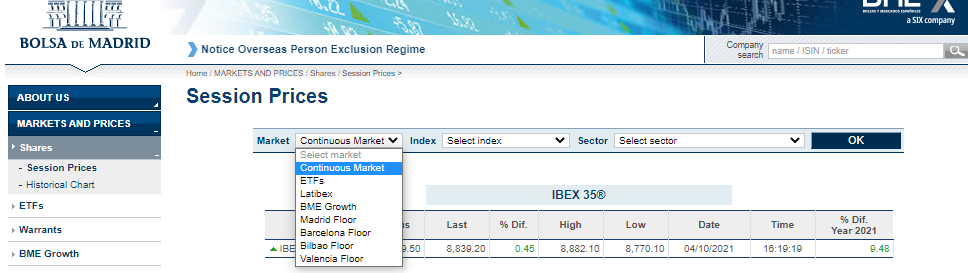

A més quan la taula conté molts elements, apareix abaix un link `All` que hem de prémer per a que mostri tots els registres.

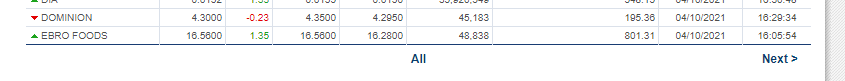

In [6]:
class MadridStockExchange:
  '''
  Class to parse the stock exchange data for all the markets available in
  the Bolsa de Madrid (Madrid Stock Exchange) website.

  Attributes
  ----------
    delay : int
      time in seconds to wait between web requests (default: 10)
    verbose: boolean
      show progress information during parsing for debugging (default: False)
    webdriver_options: str or selenium.webdriver.chrome.options.Options object
      option object for the selenium webdriver. If we pass the string 'colab' it uses
      the optimal parameters to work in colab (headless, etc). (default: 'colab')
    markets_names: list of str
      list of markets parsed from the website
    markets: Pandas.DataFrame
      dataframe containing the markets data (parsed data)

  Methods
  -------
    get_markets()
      parses the URL and stores the information in the attribute data
    reset_markets()
      empties data           
  '''

  # URL of the base page containing market information in English
  MARKETS_URL = "https://www.bolsamadrid.es/ing/aspx/Mercados/Precios.aspx?indice=ESI100000000"

  # HTML tags used to access the URLs and parse the HTML
  MARKET_MENU_ID = 'SelMercado'  # ID of the dropdown menu used to select the market
  OK_BUTTON_ID = 'ctl00_Contenido_Consultar' # ID of the button to send the request
  ALL_LINK_ID = 'ctl00_Contenido_Todos' # ID of the link to show all the rows
  TABLE_ID = 'ctl00_Contenido_tblAcciones'  # ID of the table containing the data to parse

  # Column names for the 'markets' DataFrame
  COLUMN_NAMES = ["Market", "Name", "Last", "Percent_Diff", "High", "Low", "Volume", "Turnover", "Date", "Time"]


  def __init__(self, delay=10, verbose=False, webdriver_options='colab'):

    self.delay = delay
    self.verbose = verbose
    self.market_list = []
    self.markets = pd.DataFrame(columns=self.COLUMN_NAMES)

    if isinstance(webdriver_options, webdriver.chrome.options.Options):
      self.webdriver_options = webdriver_options
    elif webdriver_options=='colab':
      self.webdriver_options = webdriver.ChromeOptions()
      self.webdriver_options.add_argument('--headless')
      self.webdriver_options.add_argument('--no-sandbox')
      self.webdriver_options.add_argument('--disable-dev-shm-usage')

    self.webdriver = webdriver.Chrome(options=self.webdriver_options)
    self.webdriver.get(self.MARKETS_URL)


  def get_markets(self):

    # Reset data
    self.reset_markets()

    # Get the markets names from the dropdown menu of the website
    self.markets_names = self.__parse_markets_names__();

    # For each market, access the corresponding page, retrieve the HTML
    # and parse the data
    for market in tqdm(self.markets_names):

      page_html = self.__get_html__(market)

      if self.verbose: print(f'Parsing market: {market}', end='...')

      new_data = self.__parse_html_table__(market, page_html)
      self.markets = self.markets.append(new_data, ignore_index=True)
      
      if self.verbose: print(f'Done.\n')
 
    # Cleaning data, e.g. remove "comas" used as thousands separator
    if self.verbose: print(f'Cleaning data', end='...')
    self.markets.replace(",","", regex=True, inplace=True)
    if self.verbose: print(f'Done.')

    if self.verbose: print(f'Parsing finished.')


  def reset_markets(self):

    self.markets = pd.DataFrame(columns=self.COLUMN_NAMES)
    if self.verbose: print(f'Attribute [markets] reseted (empty).')

  def __parse_markets_names__(self):
  
    # The list of markets available on the web is retreived from the
    # elements on the "Market" dropdown menu

    if self.verbose: print(f"Parsing market list", end="...")
  
    soup = BeautifulSoup(self.webdriver.page_source, "html.parser")
    markets_menu = soup.find(id=self.MARKET_MENU_ID).find_all("option")
    markets_names = [item.get_text() for item in markets_menu[1:]]  # We skip the first item which is the title of the menu
  
    if self.verbose: print(f"Done.")
  
    return markets_names


  def __get_html__(self, market):

    # Select the market on the dropdown menu and press the OK button (using Selenium)
    if self.verbose: print(f'Selecting new market on [Market] dropdown menu: {market}', end='...') 
    select = Select(self.webdriver.find_element_by_id(self.MARKET_MENU_ID))
    select.select_by_visible_text(market)
    if self.verbose: print(f'Done.') 

    if self.verbose: print(f'Pressing [OK] button', end='...') 
    self.webdriver.find_element_by_id(self.OK_BUTTON_ID).click()
    if self.verbose: print(f'Done.') 
    
    # Delay
    if self.verbose: print(f'Waiting {self.delay} seconds', end='...') 
    time.sleep(self.delay)
    if self.verbose: print(f'Done.') 

    # If the table contains many rows, the page shows at the bottom a link
    # with the text "ALL" that needs to be pressed to show the full table
    # Otherwise this link is missing (so we need to put it in a try/except block)

    try:
      link = self.webdriver.find_element_by_id(self.ALL_LINK_ID)
      if self.verbose: print(f'Pressing [All] link to show all the information', end='...')
      link.click()
      if self.verbose: print(f'Done.') 
    except:
      if self.verbose: print(f'There is no [All] link on this page. Skipped.')
    
    return self.webdriver.page_source


  def __parse_html_table__(self, market, page_html):

    # The data on the website is stored in html tables.
    # The html table is parsed and the extracted data stored in a Pandas DataFrame.
    # The first column of the DataFrame contains the market name (not present
    # in the html table)

    soup = BeautifulSoup(page_html, "html.parser")
    table = soup.find(id=self.TABLE_ID)
    
    new_data = pd.DataFrame(columns=self.COLUMN_NAMES)
    
    for row in table.find_all('tr')[1:]:

      row_data = [market] + [x.get_text() for x in row.find_all('td')]
    
      # If the company is suspended, the last two columns are merged in a single
      # one with the text "Suspendido xx/xx/xx". In this case row_data will have
      # one column less when parsed, so we will duplicate the last one.
      if len(row_data) == len(self.COLUMN_NAMES) - 1:
          row_data = row_data + row_data[-1:]
    
      new_data.loc[len(new_data)] = row_data    
    
    return new_data

In [7]:
m = MadridStockExchange(delay=3, verbose=True, webdriver_options='colab')
m.get_markets()

Attribute [markets] reseted (empty).
Parsing market list...Done.


  0%|          | 0/8 [00:00<?, ?it/s]

Selecting new market on [Market] dropdown menu: Continuous Market...Done.
Pressing [OK] button...Done.
Waiting 3 seconds...Done.
Pressing [All] link to show all the information...Done.
Parsing market: Continuous Market...Done.

Selecting new market on [Market] dropdown menu: ETFs...Done.
Pressing [OK] button...Done.
Waiting 3 seconds...Done.
There is no [All] link on this page. Skipped.
Parsing market: ETFs...Done.

Selecting new market on [Market] dropdown menu: Latibex...Done.
Pressing [OK] button...Done.
Waiting 3 seconds...Done.
There is no [All] link on this page. Skipped.
Parsing market: Latibex...Done.

Selecting new market on [Market] dropdown menu: BME Growth...Done.
Pressing [OK] button...Done.
Waiting 3 seconds...Done.
Pressing [All] link to show all the information...Done.
Parsing market: BME Growth...Done.

Selecting new market on [Market] dropdown menu: Madrid Floor...Done.
Pressing [OK] button...Done.
Waiting 3 seconds...Done.
There is no [All] link on this page. Skipped

In [8]:
# Show some items of the dataset
m.markets.sample(15)

,Market,Name,Last,Percent_Diff,High,Low,Volume,Turnover,Date,Time
151,Latibex,GERDAU PREF.,4.4000,-,-,-,-,-,05/10/2021,Close
162,BME Growth,ADL BIONATUR,0.8480,3.41,0.8700,0.8060,522102,437.40,06/10/2021,13:05:16
258,BME Growth,ORES,1.0500,-,-,-,-,-,05/10/2021,Close
3,Continuous Market,ACCIONA ENER,26.6000,-3.52,27.8300,26.4000,48316,1302.71,06/10/2021,13:04:09
47,Continuous Market,DIA,0.0154,3.36,0.0164,0.0149,110616320,1756.59,06/10/2021,13:04:03
148,Latibex,ELECTRO.D19B,0.0100,-,-,-,-,-,05/12/2019,Close
234,BME Growth,IZERTIS,8.0400,-2.90,8.3400,8.0400,3854,31.38,06/10/2021,13:04:30
43,Continuous Market,CORP. ALBA,47.5000,-0.84,47.6500,47.3500,12195,578.92,06/10/2021,12:59:10
191,BME Growth,EIDF,16.6000,0.61,16.6000,16.6000,200,3.32,06/10/2021,12:00:27
235,BME Growth,JABA I,1.0900,-,-,-,-,-,05/10/2021,Close


In [9]:
# Save in CSV file
m.markets.to_csv('MadridStockExchange_dataset.csv')

## Exercici 2
Documenta en un word el teu conjunt de dades generat amb la informació que tenen els diferents arxius de Kaggle.

PDF disponible a github:

https://github.com/itacademy-rogergallart/web_scraping/blob/main/MadridStockMarkets_Dataset_Readme.pdf


## Exercici 3
Tria una página web que tu vulguis i realitza web scraping mitjançant la llibreria Scrapy. 



In [10]:
# Install scrapy
!pip install scrapy &> /dev/null

In [14]:
# Install crochet 
# (needed to be able to run scrapy in Google Colab several times 
#  without having to restarting the kernel each time)
!pip install crochet &> /dev/null

In [18]:
import re
import scrapy
from scrapy.crawler import CrawlerRunner
from crochet import setup, wait_for
setup() # Important

In [40]:
class GoodReadsSpider(scrapy.Spider):
    name = "GoodReads"

    start_urls = ["https://www.goodreads.com/list/show/1.Best_Books_Ever"]

    custom_settings = {
      'FEED_FORMAT':'csv', 
      'FEED_URI': 'bestbooks.csv',
      'FEED_EXPORT_ENCODING':'utf-8',
      'USER_AGENT':'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
      }
    
    def parse(self, response):

        positions = response.selector.xpath('//td[@class="number"]/text()').getall()
        books = response.selector.xpath('//a[@class="bookTitle"]/span[@itemprop="name"]/text()').getall()
        authors = response.selector.xpath('//a[@class="authorName"]/span[@itemprop="name"]/text()').getall()
        ratings = response.selector.xpath('//span[@class="minirating"]/text()').getall()

        scores_votes = response.selector.xpath('//span[@class="smallText uitext"]/a/text()').getall()
        scores_votes = [scores_votes[i:i + 2] for i in range(0, len(scores_votes), 2)]
        
        # Split scores and number of votes in separate lists
        pattern = re.compile("([0-9.,]+)")
        scores, votes = [], []
        for item in scores_votes:
          new_score = pattern.search(item[0]).group(0).replace(",","")
          new_vote = pattern.search(item[1]).group(0).replace(",","")
          scores.append(new_score)
          votes.append(new_vote)

        # Split average rating and number of ratings in separate lists 
        avg_ratings, num_ratings = [], []
        for item in ratings:
          foo = pattern.findall(item)
          new_avg_rating = pattern.findall(item)[0].replace(",","")
          new_num_ratings = pattern.findall(item)[1].replace(",","")
          avg_ratings.append(new_avg_rating)
          num_ratings.append(new_num_ratings) 

        # Result
        for item in zip(positions, books, authors, avg_ratings, num_ratings, scores, votes):
            yield {
                'position': item[0],
                'book': item[1],
                'author': item[2],
                'avg_rating': item[3],
                'num_ratings': item[4],
                'score': item[5],
                'num_votes': item[6]
            }

In [29]:
@wait_for(10)
def run_spider():
  crawler = CrawlerRunner()
  d = crawler.crawl(GoodReadsSpider)
  return d

In [41]:
run_spider()

El fitxer amb les dades recopilades està al GitHub:

https://github.com/itacademy-rogergallart/web_scraping/blob/main/bestbooks.csv


Mostrem les 10 primeres files aquí sota:

In [43]:
books = pd.read_csv('bestbooks.csv', index_col=0)
books.head(10)

,book,author,avg_rating,num_ratings,score,num_votes
position,,,,,,
1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.32,6988237,3164067,32235
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,2778744,2761210,28232
3,To Kill a Mockingbird,Harper Lee,4.27,4973150,2394659,24597
4,Pride and Prejudice,Jane Austen,4.27,3364393,2161526,22256
5,"Twilight (The Twilight Saga, #1)",Stephenie Meyer,3.62,5435675,1510030,15392
6,The Book Thief,Markus Zusak,4.38,2049232,1490390,15363
7,Animal Farm,George Orwell,3.96,3068661,1352072,14035
8,The Chronicles of Narnia (Chronicles of Narnia...,C.S. Lewis,4.25,570175,1292185,13497
9,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.60,118797,1239399,12918
